# Flight Performance of a Seagull and a Bat in potential flow

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import math
import os
%matplotlib inline

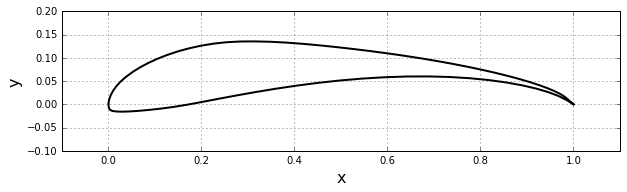

In [2]:
# import geometry and plot to check
x_gull = np.array([1.00000, .99838, .99417, .98825, .98075, .97111, .95884, .94389, .92639, .90641, .88406, .85947, .83277, .80412, .77369, .74166, .70823, .67360, .63798, .60158, .56465, .52744, .49025, .45340, .41721, .38193, .34777, .31488, .28347, .25370, .22541, .19846, .17286, .14863, .12591, .10482, .08545, .06789, .05223, .03855, .02694, .01755, .01028, .00495, .00155, .00005, .00044, .00264, .00789, .01718, .03006, .04627, .06561, .08787, .11282, .14020, .17006, .20278, .23840, .27673, .31750, .36044, .40519, .45139, .49860, .54639, .59428, .64176, .68832, .73344, .77660, .81729, .85500, .88928, .91966, .94573, .96693, .98255, .99268, .99825, 1.00000])

y_gull = np.array([0.00000, .00126, .00494, .01037, .01646, .02250, .02853, .03476, .04116, .04768, .05427, .06089, .06749, .07402, .08044, .08671, .09277, .09859, .10412, .10935, .11425, .11881, .12303, .12683, .13011, .13271, .13447, .13526, .13505, .13346, .13037, .12594, .12026, .11355, .10598, .09770, .08879, .07940, .06965, .05968, .04966, .03961, .02954, .01969, .01033, .00178, -.00561, -.01120, -.01427, -.01550, -.01584, -.01532, -.01404, -.01202, -.00925, -.00563, -.00075, .00535, .01213, .01928, .02652, .03358, .04021, .04618, .05129, .05534, .05820, .05976, .05994, .05872, .05612, .05219, .04706, .04088, .03387, .02624, .01822, .01060, .00468, .00115, 0.00000])

# plot
width = 10
plt.figure(figsize=(width,width))
plt.grid()
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.plot(x_gull, y_gull, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point
        ya: float
            y-coordinate of the first end-point
        xb: float
            x-coordinate of the second end-point
        yb: float
            y-coordinate of the second end-point
        """
        self.xa, self.ya = xa, ya     # panel starting point
        self.xb, self.yb = xb, yb     # panel end point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # panel center
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)  # panel length
        
        # orientation of the panel
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + np.arccos(-(yb-ya)/self.length)
            
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'    # upper surface
        else:
            self.loc = 'lower'    # lower surface
        
        self.sigma = 0.0     # source strength
        self.vt = 0.0        # tangential velocity
        self.cp = 0.0        # coefficient of pressure

In [4]:
def define_panels(x, y, N=150):
    """
    Discretizes the geometry into panels_gull using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels_gull;
        default: 40.
        
    Returns
    -------
    panels_gull: 1D numpy array of Panel objects
        The list of panels_gull.
    """
    R = (x.max()-x.min())/2                            # radius of the circle
    x_center = (x.max()+x.min())/2                     # x-coordinate of the circle center
    
    theta = np.linspace(0, 2*np.pi, N+1)             # array of angles
    x_circle = x_center + R*np.cos(theta)              # x-coordinates of the circle
    
    x_ends = np.copy(x_circle)                           # x-coordinate of the panels_gull end-points
    y_ends = np.empty_like(x_ends)                     # y-coordinate of the panels_gull end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of the end-points by projection
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels_gull
    panels_gull = np.empty(N, dtype = object)
    for i in range(N):
        panels_gull[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels_gull

In [5]:
# discretize geometry into panels_gull
panels_gull = define_panels(x_gull, y_gull, N=150)

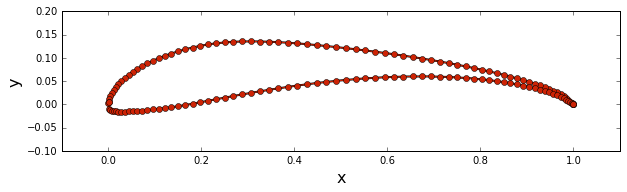

In [6]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_gull, y_gull, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels_gull], panels_gull[0].xa),
         np.append([panel.ya for panel in panels_gull], panels_gull[0].ya),
         linestyle='-', linewidth=1, color='#CD2305', marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

# Zero Angle of Attack

In [7]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180.0  # degrees to radians

In [8]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [9]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
# weight from each source on the normal velocity of each panel
def source_contribution_normal(panels_gull):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels_gull.size, panels_gull.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels_gull):
        for j, panel_j in enumerate(panels_gull):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [11]:
def vortex_contribution_normal(panels_gull):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels_gull.size, panels_gull.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels_gull):
        for j, panel_j in enumerate(panels_gull):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [12]:
# call functions to create source matrix and vortex matrix
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [13]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [15]:
def build_freestream_rhs(panels_gull, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_gull.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_gull):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_gull[0].beta)
                               +np.sin(freestream.alpha-panels_gull[-1].beta) )
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [17]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [18]:
print(gamma)

0.372866336528


## Surface Pressure @ $AoA=0$

In [19]:
def compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [20]:
# compute tangential velocity at each panel center
compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex)

In [21]:
def compute_pressure_coefficient(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [22]:
# surface pressure coefficient
compute_pressure_coefficient(panels_gull, freestream)

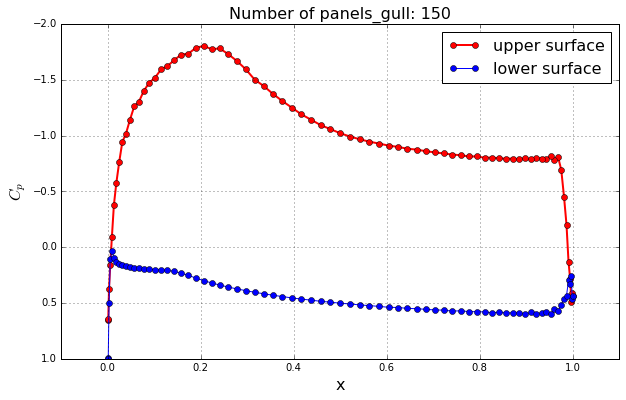

In [23]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -2.0)
plt.title('Number of panels_gull: {}'.format(panels_gull.size), fontsize=16);

## Accuracy check (sum of singularities = 0)

In [24]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000118


## Calculate $C_L$ at $AoA=0$

In [25]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_0 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=0: CL_0 = {:0.3f}'.format(cl_0))

lift coefficient at AoA=0: CL_0 = 1.566


# Angle of Attack = 5 Degrees

In [26]:
# define freestream conditions with new AoA
freestream = Freestream(u_inf=1.0, alpha=5.0)

In [27]:
# define new freestream RHS of matrix equation
def build_freestream_rhs(panels_gull, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_gull.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_gull):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_gull[0].beta)
                               +np.sin(freestream.alpha-panels_gull[-1].beta) )
    return b

In [28]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [29]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [30]:
print(gamma)

0.510034378172


## Surface Pressure at $AoA=5$

In [31]:
def compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [32]:
# compute tangential velocity at each panel center
compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex)

In [33]:
def compute_pressure_coefficient(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [34]:
# surface pressure coefficient
compute_pressure_coefficient(panels_gull, freestream)

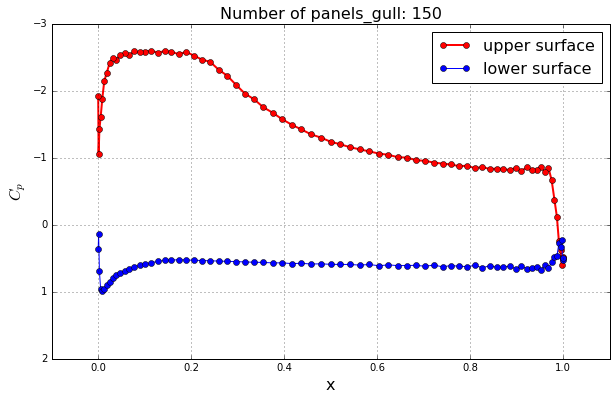

In [35]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -3.0)
plt.title('Number of panels_gull: {}'.format(panels_gull.size), fontsize=16);

In [36]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.004883


## $C_L$ at $AoA=5$

In [37]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_5 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=5: CL_5 = {:0.3f}'.format(cl_5))

lift coefficient at AoA=5: CL_5 = 2.141


# Angle of Attack = 10 Degrees

In [38]:
# define freestream conditions with new AoA
freestream = Freestream(u_inf=1.0, alpha=10.0)

In [39]:
# define new freestream RHS of matrix equation
def build_freestream_rhs(panels_gull, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_gull.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_gull):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_gull[0].beta)
                               +np.sin(freestream.alpha-panels_gull[-1].beta) )
    return b

In [40]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [41]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [42]:
print(gamma)

0.643320750231


### Surface Pressure at $AoA=10$

In [43]:
def compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [44]:
# compute tangential velocity at each panel center
compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex)

In [45]:
def compute_pressure_coefficient(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [46]:
# surface pressure coefficient
compute_pressure_coefficient(panels_gull, freestream)

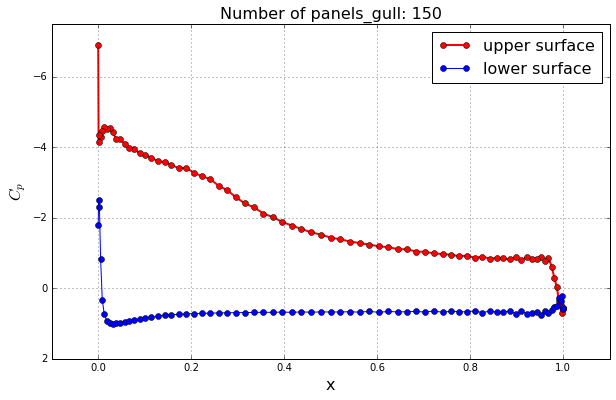

In [47]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -7.5)
plt.title('Number of panels_gull: {}'.format(panels_gull.size), fontsize=16);

In [48]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.009848


### $C_L$ at $AoA=10$

In [49]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_10 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=10: CL_10 = {:0.3f}'.format(cl_10))

lift coefficient at AoA=10: CL_10 = 2.701


# Angle of Attack = 15

In [50]:
# define new freestream conditions
freestream = Freestream(u_inf=1.0, alpha=15.0)

In [51]:
# define new freestream RHS of matrix equation
def build_freestream_rhs(panels_gull, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_gull.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_gull):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_gull[0].beta)
                               +np.sin(freestream.alpha-panels_gull[-1].beta) )
    return b

In [52]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [53]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [54]:
print(gamma)

0.771711062933


### Surface Pressure at $AoA=15$

In [55]:
def compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [56]:
# compute tangential velocity at each panel center
compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex)

In [57]:
def compute_pressure_coefficient(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [58]:
# compute pressure coefficient
compute_pressure_coefficient(panels_gull, freestream)

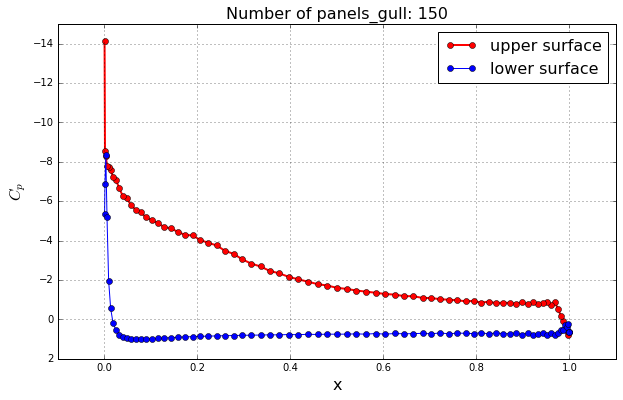

In [59]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -15.0)
plt.title('Number of panels_gull: {}'.format(panels_gull.size), fontsize=16);

### $C_L$ at $AoA=15$

In [60]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_15 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=15: CL_15 = {:0.3f}'.format(cl_15))

lift coefficient at AoA=15: CL_15 = 3.240


# Angle of Attack = 20

In [61]:
# define new freestream conditions
freestream = Freestream(u_inf=1.0, alpha=20.0)

In [62]:
# define new freestream RHS of matrix equation
def build_freestream_rhs(panels_gull, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_gull.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_gull):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_gull[0].beta)
                               +np.sin(freestream.alpha-panels_gull[-1].beta) )
    return b

In [63]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [64]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [65]:
print(gamma)

0.894228188474


### Surface Pressure at $AoA=20$

In [66]:
def compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [67]:
# compute tangential velocity at each panel center
compute_tangential_velocity(panels_gull, freestream, gamma, A_source, B_vortex)

In [68]:
def compute_pressure_coefficient(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [69]:
# compute pressure coefficient
compute_pressure_coefficient(panels_gull, freestream)

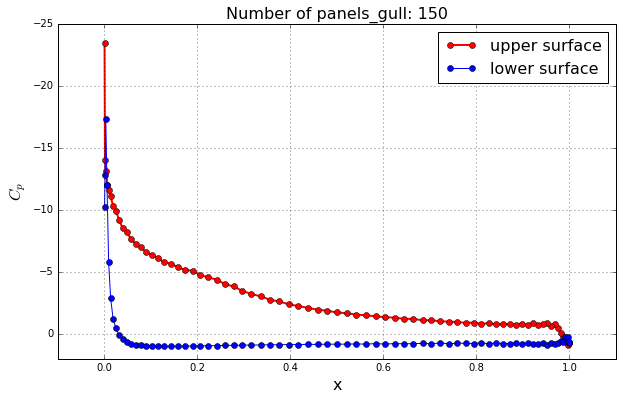

In [70]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -25.0)
plt.title('Number of panels_gull: {}'.format(panels_gull.size), fontsize=16);

### $C_L$ at $AoA=20$

In [71]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_20 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=20: CL_20 = {:0.3f}'.format(cl_20))

lift coefficient at AoA=20: CL_20 = 3.755


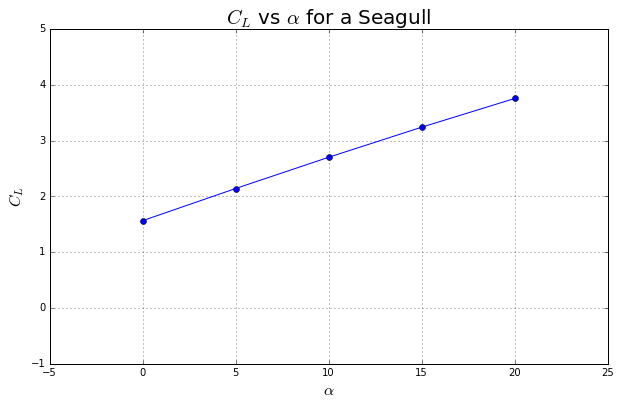

In [72]:
# plot AoA vs CL
AoA = np.array([0, 5.0, 10.0, 15.0, 20.0])
CL = np.array([cl_0, cl_5, cl_10, cl_15, cl_20])
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('$C_L$', fontsize=16)
plt.xlim(-5.0, 25)
plt.ylim(-1.0, 5.0)
plt.title(r'$C_L$ vs $\alpha$ for a Seagull', fontsize=20)
plt.plot(AoA, CL, linestyle='-', color='b', marker='o', markersize=6);

# Bat Wing Analysis

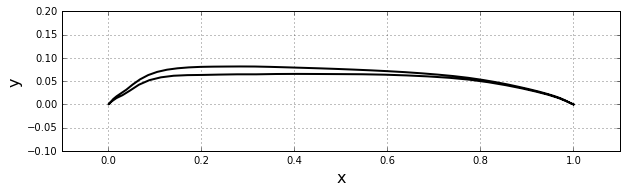

In [73]:
# Define wing coordinates
x_bat = np.array([1.00000,.99838,.99417,.98825,.98075,.97111,.95884,.94389,.92639,.90640,.88405,.85946,.83276,.80411,.77368,.74165,.70822,.67359,.63797,.60157,.56464,.52743,.49024,.45339,.41720,.38192,.34776,.31487,.28346,.25369,.22540,.19845,.17285,.14862,.12590,.10481,.08544,.06788,.05222,.03854,.02693,.01754,.01027,.00495,.00155,.00005,.00044,.00264,.00789,.01717,.03004,.04625,.06559,.08785,.11280,.14018,.17004,.20276,.23838,.27671,.31748,.36042,.40517,.45137,.49858,.54637,.59426,.64174,.68831,.73343,.77659,.81728,.85499,.88927,.91965,.94573,.96693,.98255,.99268,.99825,1.00000])

y_bat = np.array([-.00035,.00043,.00248,.00543,.00910,.01331,.01770,.02225,.02709,.03206,.03718,.04251,.04765,.05253,.05697,.06070,.06384,.06663,.06912,.07119,.07301,.07462,.07608,.07736,.07848,.07954,.08051,.08122,.08137,.08120,.08098,.08051,.07939,.07745,.07442,.06969,.06283,.05360,.04255,.03149,.02363,.01729,.01128,.00514,.00172,-.00012,.00021,.00251,.00696,.01336,.01953,.02950,.04215,.05187,.05799,.06142,.06273,.06316,.06389,.06447,.06447,.06515,.06536,.06517,.06492,.06460,.06369,.06210,.05992,.05699,.05291,.04741,.04102,.03418,.02726,.02053,.01384,.00758,.00290,.00046,-.00027])

#plot
width = 10
plt.figure(figsize=(width,width))
plt.grid()
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.plot(x_bat, y_bat, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

In [74]:
panels_bat = define_panels(x_bat, y_bat, N=150)

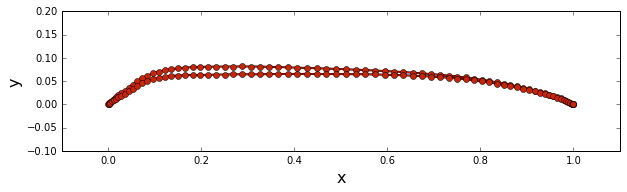

In [75]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_bat, y_bat, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels_bat], panels_bat[0].xa),
         np.append([panel.ya for panel in panels_bat], panels_bat[0].ya),
         linestyle='-', linewidth=1, color='#CD2305', marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

# Zero Angle of Attack

In [76]:
def source_contribution_normal(panels_bat):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels_bat.size, panels_bat.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels_bat):
        for j, panel_j in enumerate(panels_bat):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [77]:
def vortex_contribution_normal(panels_bat):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels_bat.size, panels_bat.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels_bat):
        for j, panel_j in enumerate(panels_bat):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [78]:
def build_freestream_rhs(panels_bat, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_bat.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_bat):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_bat[0].beta)
                               +np.sin(freestream.alpha-panels_bat[-1].beta) )
    return b

In [79]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [80]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [81]:
print(gamma)

0.848309915455


In [82]:
def compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_bat.size, panels_bat.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_bat])
    
    strengths = np.append([panel.sigma for panel in panels_bat], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_bat):
        panel.vt = tangential_velocities[i]

In [83]:
compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex)

In [84]:
def compute_pressure_coefficient(panels_bat, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_bat:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [85]:
compute_pressure_coefficient(panels_bat, freestream)

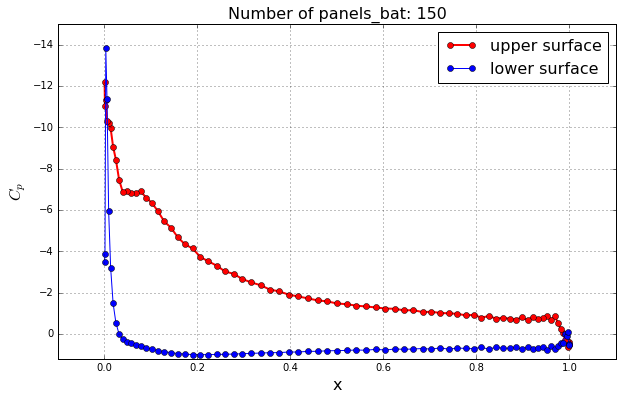

In [86]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.2, -15.0)
plt.title('Number of panels_bat: {}'.format(panels_bat.size), fontsize=16);

### $C_L$ at $AoA=0$

In [87]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_0 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=20: CL_bat_0 = {:0.3f}'.format(cl_bat_0))

lift coefficient at AoA=20: CL_bat_0 = 3.487


In [88]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.163828


# $AoA=5$

In [89]:
# define new freestream
freestream = Freestream(u_inf=1.0, alpha=5.0)

In [90]:
def build_freestream_rhs(panels_bat, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_bat.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_bat):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_bat[0].beta)
                               +np.sin(freestream.alpha-panels_bat[-1].beta) )
    return b

In [91]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [92]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [93]:
print(gamma)

0.450267190991


In [94]:
def compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_bat.size, panels_bat.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_bat])
    
    strengths = np.append([panel.sigma for panel in panels_bat], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_bat):
        panel.vt = tangential_velocities[i]

In [95]:
compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex)

In [96]:
def compute_pressure_coefficient(panels_bat, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_bat:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [97]:
compute_pressure_coefficient(panels_bat, freestream)

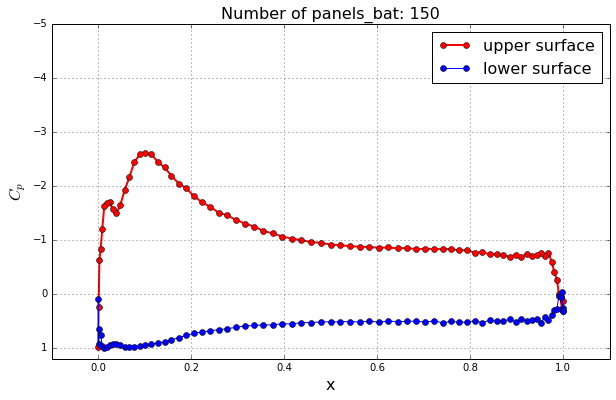

In [98]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.2, -5.0)
plt.title('Number of panels_bat: {}'.format(panels_bat.size), fontsize=16);

In [99]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_5 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=5: CL_bat_5 = {:0.3f}'.format(cl_bat_5))

lift coefficient at AoA=5: CL_bat_5 = 1.851


In [100]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.041981


# $AoA=10$

In [101]:
# new freestream
freestream = Freestream(u_inf=1.0, alpha=10.0)

In [102]:
def build_freestream_rhs(panels_bat, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_bat.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_bat):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_bat[0].beta)
                               +np.sin(freestream.alpha-panels_bat[-1].beta) )
    return b

In [103]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [104]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [105]:
print(gamma)

0.587758748126


In [106]:
def compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_bat.size, panels_bat.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_bat])
    
    strengths = np.append([panel.sigma for panel in panels_bat], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_bat):
        panel.vt = tangential_velocities[i]

In [107]:
compute_tangential_velocity(panels_bat, freestream, gamma, A_source, B_vortex)

In [108]:
def compute_pressure_coefficient(panels_bat, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_bat:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [109]:
compute_pressure_coefficient(panels_bat, freestream)

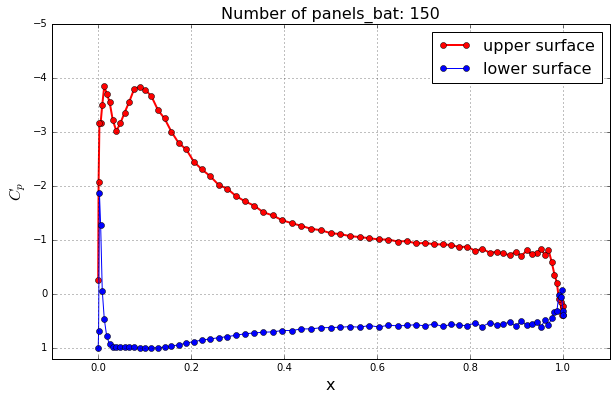

In [110]:
# plot surface pressure coefficient
plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.2, -5.0)
plt.title('Number of panels_bat: {}'.format(panels_bat.size), fontsize=16);

In [111]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_10 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=10: CL_bat_10 = {:0.3f}'.format(cl_bat_10))

lift coefficient at AoA=10: CL_bat_10 = 2.416


In [112]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.083334
